資料的突出值要去掉

In [181]:
import pandas as pd
import numpy as np

In [182]:
data = pd.read_csv("./Data/Taipei/h23-g1.csv",delimiter=';')

In [183]:
print(data)

                 date_time            E             N         H  Angle  Axis  \
0      2023-03-22 12:10:00  320191.8741  2.771896e+06  287.4545    0.0   0.0   
1      2023-03-22 12:20:00  320191.8742  2.771896e+06  287.4555    0.0   0.0   
2      2023-03-22 12:30:00  320191.8749  2.771896e+06  287.4554    0.0   0.0   
3      2023-03-22 12:40:00  320191.8757  2.771896e+06  287.4576    0.0   0.0   
4      2023-03-22 12:50:00  320191.8771  2.771896e+06  287.4603    0.0   0.0   
...                    ...          ...           ...       ...    ...   ...   
74028  2024-12-15 10:40:00  320191.8353  2.771896e+06  287.4683   35.0   5.4   
74029  2024-12-15 10:50:00  320191.8353  2.771896e+06  287.4683   36.0   5.2   
74030  2024-12-15 11:00:00  320191.8353  2.771896e+06  287.4683   41.0   6.2   
74031  2024-12-15 11:10:00  320191.8349  2.771896e+06  287.4669   39.0   5.2   
74032  2024-12-15 11:20:00  320191.8341  2.771896e+06  287.4743   65.0   9.3   

       Plate  EMove  NMove  HMove  Tota

In [184]:
data['date_time'] = pd.to_datetime(data['date_time'])
data['date_time'] = data['date_time'].astype(int) / (10 ** 11)

In [185]:
print(data['date_time'])

0        16794870.0
1        16794876.0
2        16794882.0
3        16794888.0
4        16794894.0
            ...    
74028    17342592.0
74029    17342598.0
74030    17342604.0
74031    17342610.0
74032    17342616.0
Name: date_time, Length: 74033, dtype: float64


In [186]:
# Remove values outside 3 standard deviations
target = ['EMove', 'NMove', 'HMove']

for col in target:
    mean = data[col].mean()
    std = data[col].std()
    data = data[(data[col] >= mean - 3*std) & (data[col] <= mean + 3*std)]

In [187]:
lag_features = ['EMove', 'NMove', 'HMove']
lag_steps = 3

for feature in lag_features:
    for lag in range(1, lag_steps + 1):
        data[f'{feature}_lag{lag}'] = data[feature].shift(lag)

data = data.dropna()

In [188]:
features = ["date_time"] + [f"{feature}_lag1" for feature in lag_features] + [f"{feature}_lag2" for feature in lag_features] + [f"{feature}_lag3" for feature in lag_features]

X = data[features]
y = data[target]

In [189]:
import xgboost as xgb
from sklearn.model_selection import train_test_split

In [190]:
X_train = X[:int(len(X)*0.9)]
X_test = X[int(len(X)*0.9):]
y_train = y[:int(len(y)*0.9)]
y_test = y[int(len(y)*0.9):]

In [191]:
xgbrModel=xgb.XGBRegressor(
    n_estimators=300,      # 樹的數量
    max_depth=8,           # 樹的最大深度
    learning_rate=0.05,    # 學習率
    subsample=0.8,         # 訓練數據取樣比例
    colsample_bytree=0.8,  # 特徵取樣比例
    reg_lambda=10,          # L2 正則化
    reg_alpha=1,         # L1 正則化
    min_child_weight=1,    # 限制葉子節點最小權重
    gamma=0.1,             # 節點劃分限制
    random_state=42)
xgbrModel.fit(X_train,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.1, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=300, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [192]:
y_pred = xgbrModel.predict(X_test)

In [193]:
print(y_pred)

[[-26.542217   60.759842   21.257257 ]
 [-28.018402   60.55942    23.456854 ]
 [-26.96633    60.292694   26.424065 ]
 ...
 [-32.71473    62.56987    10.632485 ]
 [-32.71473    62.56987    10.632485 ]
 [-32.60741    62.503956    5.1251945]]


In [194]:
from sklearn.metrics import mean_squared_error,mean_absolute_error

E_mae = mean_absolute_error(y_test['EMove'], y_pred[:,0])
E_rmse = np.sqrt(mean_squared_error(y_test['EMove'], y_pred[:,0]))

N_mae = mean_absolute_error(y_test['NMove'], y_pred[:,1])
N_rmse = np.sqrt(mean_squared_error(y_test['NMove'], y_pred[:,1]))

H_mae = mean_absolute_error(y_test['HMove'], y_pred[:,2])
H_rmse = np.sqrt(mean_squared_error(y_test['HMove'], y_pred[:,2]))

#TotalM_mae = mean_absolute_error(y_test['TotalMove'], y_pred[:,3])
#TotalM_rmse = np.sqrt(mean_squared_error(y_test['TotalMove'], y_pred[:,3]))

results = pd.DataFrame({
    "Variable": ["EMove","NMove","HMove"],
    "MAE": [E_mae,N_mae,H_mae],
    "RMSE": [E_rmse,N_rmse,H_rmse]
})

print("results:")
print(results)
print('\n')

for t in target:
    y_min = np.min(y_test[t], axis=0)  # 最小值
    y_max = np.max(y_test[t], axis=0)  # 最大值
    y_range = y_max - y_min
    print(t,"range:",y_range)
    y_std = np.std(y_test[t], axis=0) 
    print(t,"std:",y_std,'\n')

results:
  Variable       MAE      RMSE
0    EMove  4.522682  6.469722
1    NMove  3.938585  6.129418
2    HMove  2.554712  3.916889


EMove range: 40.9
EMove std: 6.9910585047177864 

NMove range: 70.2
NMove std: 10.966461437410606 

HMove range: 80.2
HMove std: 9.092245350775663 



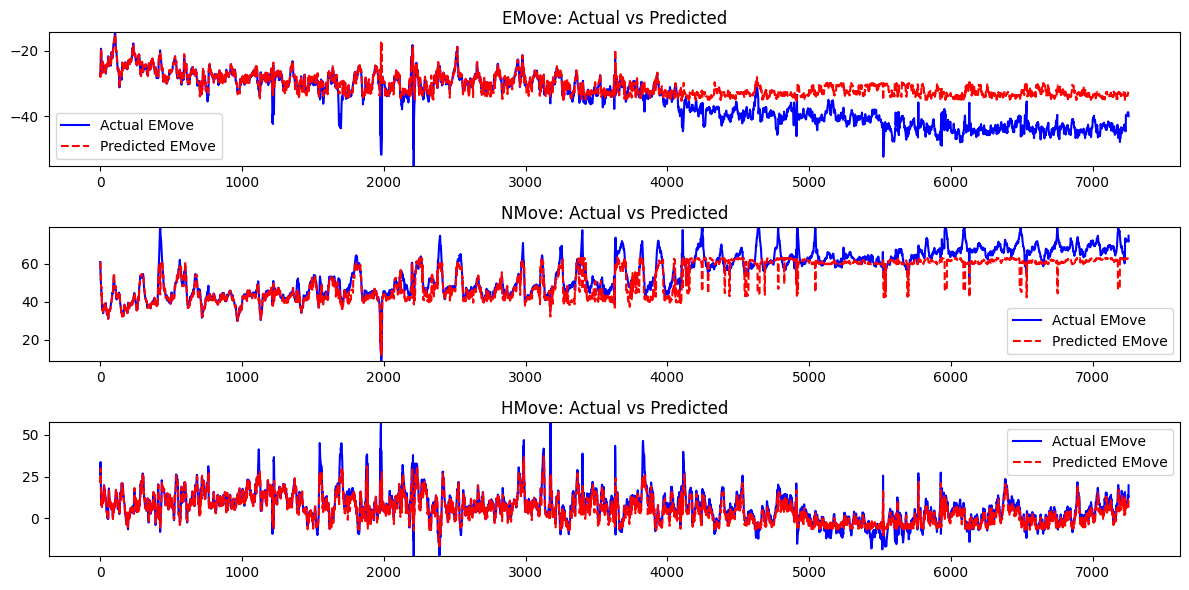

In [195]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Plot predictions vs actual values for each movement component
y_min = -50  # 最小值
y_max = 50  # 最大值
plt.figure(figsize=(12, 6))
subplot_i=0

for t in target:
    plt.subplot(3, 1, subplot_i+1)
    y_min = min([ np.min(y_test[t].to_numpy(), axis=0) , np.min(y_pred[:,subplot_i], axis=0) ])
    y_max = max([ np.max(y_test[t].to_numpy(), axis=0) , np.max(y_pred[:,subplot_i], axis=0) ])
    plt.plot(y_test[t].to_numpy(), label="Actual EMove", color='blue')
    plt.plot(y_pred[:,subplot_i], label="Predicted EMove", color='red', linestyle='dashed')
    plt.title("{}: Actual vs Predicted".format(t))
    plt.ylim(y_min, y_max)  # Set same y-axis range
    plt.legend()
    subplot_i += 1

plt.tight_layout()
plt.show()